[](https://)<a href="https://drive.google.com/file/d/107QmxJyoMd--MaRCYDB0xRmFnz11_7Hb/view?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Label Text Classification of Telugu Abstractive Summaries


### Import necessary libraries for the experiment

In [ ]:
# importing libraries
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import text, sequence
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.models import Model, Input, Sequential
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, SpatialDropout1D, Activation
from keras.layers import Conv1D, Bidirectional, GlobalMaxPool1D, MaxPooling1D, BatchNormalization
#from keras.optimizers import adam
from tensorflow.keras.optimizers import Adam
from keras.utils.vis_utils import plot_model

# For custom metrics
import keras.backend as K
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping 


import pandas as pd
import numpy as np
 
import matplotlib.pyplot as plt

plt.style.use('seaborn')

import seaborn as sns
from IPython.display import Image

from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer 
import os, re, csv, math, codecs
from nltk.tokenize import word_tokenize
import string
import gensim
import os

sns.set_style("whitegrid")
np.random.seed(0)
!pip install chart_studio
import chart_studio.plotly as py
import plotly.graph_objs as go
#import plotly.plotly as py
#import plotly.graph_objs as go
import plotly
import chart_studio
chart_studio.tools.set_credentials_file(username='hamzasharoon', api_key='9le0c8M5GUNRAKyJoIt2')


# Install dependencies
!apt install graphviz
!pip install pydot pydot-ng
!echo "Double check with Python 3"
!python -c "import pydot"

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
Double check with Python 3


### Loading the necessary data files and data Preparation

In [ ]:
#Train data
#train = pd.read_csv('train.csv')
#new_df = pd.read_csv('/content/drive/MyDrive/Summary_evaluation/Relevance_final.csv', delimiter=',')
#new_df = pd.read_csv('/content/drive/MyDrive/Summary_evaluation/readability_final.csv', delimiter=',')
new_df = pd.read_csv('/content/drive/MyDrive/Summary_evaluation/relevance_overall_data.csv', delimiter=',')
new_df.head(5)

,text,Relevant information is missing,Irrelevant information is added,Out of context information is added,Misleading original context,Factual incorrectness,Repetitive information is found
0,విజయవాడలో ఆర్టీసీ కార్మిక సంఘాల నేతలతో ఎండీ సు...,0,0,0,0,0,1
1,ఆర్టీసీ యాజమాన్యంతో నిర్వహించిన చర్చలు విఫలమయ్...,0,0,0,0,0,0
2,తెలంగాణ ముఖ్యమంత్రి కేసీఆర్ జగిత్యాల జిల్లాలోన...,0,0,0,0,0,0
3,జీఎస్పీ ( జనరలైజుడ్ సిస్టం ఆఫ్ ప్రిఫరెన్సెస్) ...,0,0,0,0,0,0
4,ఈ ఆగస్టు 15 నాటికి నాలుగు లక్షల మందికి ఉద్యోగా...,0,0,0,0,0,0


In [ ]:
train_size = 0.8
train=new_df.sample(frac=train_size,random_state=200)
test=new_df.drop(train.index).reset_index(drop=True)
train = train.reset_index(drop=True)
#train["unnatural sentence formations "]

### Number of records in the train and test data

In [ ]:
print("Train data shape", train.shape)
print("Test data shape", test.shape)

Train data shape (1856, 7)
Test data shape (464, 7)


In [ ]:
# check that there are no missing values in either training set
print('The dataset has', train.isna().sum().sum(), 'missing values in train data.')
print('The dataset has', test.isna().sum().sum(), 'missing values in test data.')

# check if there are any duplicates
print('The dataset has', train.duplicated().sum(), 'duplicates in train data.')
print('The dataset has', test.duplicated().sum(), 'duplicates in test data.')

The dataset has 0 missing values in train data.
The dataset has 0 missing values in test data.
The dataset has 1 duplicates in train data.
The dataset has 1 duplicates in test data.


### CORRELATION BETWEEN DATA LABELS

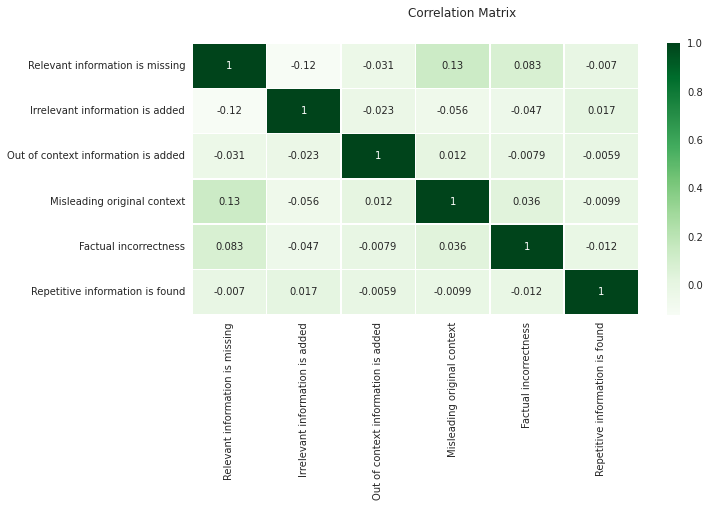

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Correlation Matrix')
sns.heatmap(train.corr(), annot=True, cmap="Greens", linewidths=.5, ax=ax);

### DATA PREPROCESSING
Deep Neural Networks input layers make use of input variables to feed the network for training the model. But in this task (experiment), we're dealing with words text. How do we represent these words in order to feed our model?

In our experiment, we used densed representation of those text (comments) and their semanticity together. The advantage of using this approach is the best way for fitting neural networks onto a text data (as in our case), as well as less memory usage compared to other sparse representation approaches.


#### Word Embedding
Two ways to feed embeddings to neural networks:
   * Using your own word embeddings by training
   * Using pre-trained embedding (e.g Word2vec, FastText, Glove etc)
   


In [ ]:
#Convert text to vectors using keras preprocessing library tools

X_train = train["text"].values
X_test  = test["text"].values
# Below two lines work for relevance with zero labels
y_train = train[["Relevant information is missing", "Irrelevant information is added", "Out of context information is added", "Misleading original context", "Factual incorrectness", "Repetitive information is found"]].values
y_test = test[["Relevant information is missing", "Irrelevant information is added", "Out of context information is added", "Misleading original context", "Factual incorrectness", "Repetitive information is found"]].values
# Below two lines work for relevance without zero labels
#y_train = train[["Relevant information is missing", "Irrelevant information added", "Out of context information added", "Misleading original context", "Factual incorrectness", "Repetitive information found"]].values
#y_test = test[["Relevant information is missing", "Irrelevant information added", "Out of context information added", "Misleading original context", "Factual incorrectness", "Repetitive information found"]].values
#y_train = train[["syntax or semantic errors", "coherence issue", "understandability issue", "unnatural sentence formations "]].values
#y_test = test[["syntax or semantic errors", "coherence issue", "understandability issue", "unnatural sentence formations "]].values
#y_train = train[["Lengthy summary", "Novel sentence structure is missing","Copied sentences present", "Sentence formation needs to be improved" ]].values
#y_test = test[["Lengthy summary", "Novel sentence structure is missing","Copied sentences present", "Sentence formation needs to be improved"]].values


#y_test  = test[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values






For the first embedding, we used keras preprocessing (Text Preprocessing) libraries. This class allows to vectorize a text corpus, by turning each text into either a sequence of integers (each integer being the index of a token in a dictionary) or into a vector where the coefficient for each token could be binary, based on word count, based on tf-idf

In [ ]:
num_words = 200 ## default=20000#Max. workds to use per article-summary pair
max_features = 20000 #default = 200000#Max. number of unique words in embeddinbg vector
max_len = 200 #default= 200#Max. number of words per comment mistake to be use
embedding_dims = 128 #embedding vector output dimension 
num_epochs =  100 #4 #default=25 # (before 5)number of epochs (number of times that the model is exposed to the training dataset)
val_split = 0.1
batch_size2 = 32 #default=32 #(before 32)The **batch size** is the number of training examples in one forward/backward pass.
                  # In general, larger batch sizes result in faster progress in training, but don't always converge as quickly. 
                  #Smaller batch sizes train slower, but can converge faster. And the higher the batch size, the more memory space you’ll need.

In [ ]:

#article-summary pair Tokenization
tokenizer = tokenizer = Tokenizer(num_words)
tokenizer.fit_on_texts(list(X_train))

#Convert tokenized article-summary pair data into sequnces
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
 
# padding the sequences
X_train = sequence.pad_sequences(X_train, max_len)
X_test  = sequence.pad_sequences(X_test,  max_len)

print('X_train shape:', X_train.shape)
print('X_test shape: ', X_test.shape)

X_train shape: (1856, 200)
X_test shape:  (464, 200)


### Train, Validation, Test Splits

#### Our Experiment Splits Ratio
Split ratio on most of the experimental datasets depends mainly on two (2) things: The number of samples in the data, and the actual model you are training. We have used the 80% for training and 20% of the data for testing purpose.



## METHODS (NN, CNN, RNN, LSTM)

#### We used early callback functionality that allows you to specify the performance measure to monitor, the trigger, and once triggered. It will stop the training process.

In [ ]:
early = EarlyStopping(monitor="val_loss", mode="min", patience=4)

#### Using Precision, Recall, F1-Measure, AUC, mean etc evaluaiton metrics to evaluate our model

In [ ]:
#Import necessary libraries
4# demonstration of calculating metrics for a neural network model using sklearn
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix


def precision(y_true, y_pred):
    '''Calculates the precision, a metric for multi-label classification of
    how many selected items are relevant.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    '''Calculates the recall, a metric for multi-label classification of
    how many relevant items are selected.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

  #Customized the evaluation to analyse the model in terms of accuracy and mean value accuracy
def mean_pred(y_true, y_pred):
    return K.mean(y_pred)

def fbeta_score(y_true, y_pred, beta=1):
    '''Calculates the F score, the weighted harmonic mean of precision and recall.
    This is useful for multi-label classification, where input samples can be
    classified as sets of labels. By only using accuracy (precision) a model
    would achieve a perfect score by simply assigning every class to every
    input. In order to avoid this, a metric should penalize incorrect class
    assignments as well (recall). The F-beta score (ranged from 0.0 to 1.0)
    computes this, as a weighted mean of the proportion of correct class
    assignments vs. the proportion of incorrect class assignments.
    With beta = 1, this is equivalent to a F-measure. With beta < 1, assigning
    correct classes becomes more important, and with beta > 1 the metric is
    instead weighted towards penalizing incorrect class assignments.
    '''
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')
        
    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score

def auroc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc


def fmeasure(y_true, y_pred):
    '''Calculates the f-measure, the harmonic mean of precision and recall.
    '''
    return fbeta_score(y_true, y_pred, beta=1)


fscore = f1score = fmeasure

### 1) Neural Network (NN)

In [ ]:
nn_model = Sequential([
    Embedding(input_dim=max_features, input_length=max_len, output_dim=embedding_dims),
    GlobalMaxPool1D(),
    Dense(50, activation = 'relu'),
    Dropout(0.3),
    Dense(6, activation = 'sigmoid')
])

### Compile the NN model

In [ ]:
#Customized the evaluation to analyse the model in terms of accuracy and mean value accuracy
def mean_pred(y_true, y_pred):
    return K.mean(y_pred)

def precision(y_true, y_pred):
    '''Calculates the precision, a metric for multi-label classification of
    how many selected items are relevant.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    '''Calculates the recall, a metric for multi-label classification of
    how many relevant items are selected.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def mean_pred(y_true, y_pred):
    return K.mean(y_pred)

def fbeta_score(y_true, y_pred, beta=1):
    '''Calculates the F score, the weighted harmonic mean of precision and recall.
    This is useful for multi-label classification, where input samples can be
    classified as sets of labels. By only using accuracy (precision) a model
    would achieve a perfect score by simply assigning every class to every
    input. In order to avoid this, a metric should penalize incorrect class
    assignments as well (recall). The F-beta score (ranged from 0.0 to 1.0)
    computes this, as a weighted mean of the proportion of correct class
    assignments vs. the proportion of incorrect class assignments.
    With beta = 1, this is equivalent to a F-measure. With beta < 1, assigning
    correct classes becomes more important, and with beta > 1 the metric is
    instead weighted towards penalizing incorrect class assignments.
    '''
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')
        
    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score

def auroc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc


def fmeasure(y_true, y_pred):
    '''Calculates the f-measure, the harmonic mean of precision and recall.
    '''
    return fbeta_score(y_true, y_pred, beta=1)


fscore = f1score = fmeasure



nn_model.compile(loss='binary_crossentropy', optimizer=Adam(0.01), metrics=['accuracy', precision, recall, mean_pred])

### Visualize the Orchestrated NN Architecture

In [ ]:
nn_model_fit = nn_model.fit(X_train, y_train, batch_size=batch_size2, epochs=num_epochs, validation_split=val_split, callbacks=[early])

Epoch 1/4
53/53 [==============================] - 3s 34ms/step - loss: 0.3224 - accuracy: 0.4952 - precision: 0.0509 - recall: 0.0467 - mean_pred: 0.1523 - val_loss: 0.2223 - val_accuracy: 0.8387 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_mean_pred: 0.0751
Epoch 2/4
53/53 [==============================] - 2s 30ms/step - loss: 0.2231 - accuracy: 0.7329 - precision: 0.0189 - recall: 0.0012 - mean_pred: 0.0771 - val_loss: 0.2299 - val_accuracy: 0.8387 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_mean_pred: 0.0910
Epoch 3/4
53/53 [==============================] - 2s 29ms/step - loss: 0.2052 - accuracy: 0.7838 - precision: 0.0377 - recall: 0.0026 - mean_pred: 0.0720 - val_loss: 0.2334 - val_accuracy: 0.8333 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_mean_pred: 0.0750
Epoch 4/4
53/53 [==============================] - 1s 28ms/step - loss: 0.1738 - accuracy: 0.7808 - precision: 0.2865 - recall: 0.0386 - mean_pred: 0.0717 - val_loss: 0.2427 - va

In [ ]:
nn_train_score = nn_model.evaluate(X_train, y_train, batch_size = batch_size2, verbose = 1)
print('Train loss:', nn_train_score[0])
print('Train accuracy:', nn_train_score[1])

58/58 [==============================] - 0s 2ms/step - loss: 0.1326 - accuracy: 0.9057 - precision: 0.8709 - recall: 0.3209 - mean_pred: 0.0712
Train loss: 0.13263246417045593
Train accuracy: 0.9057112336158752


In [ ]:
nn_test_score = nn_model.evaluate(X_test, y_test, batch_size=batch_size2, verbose=1)
print('Test Loss:', nn_test_score[0])
print('Test Accuracy:', nn_test_score[1])
#print('Test_precison:', nn_test_score[2])
#print('Test_recall:', nn_test_score[3])
p= nn_test_score[2]
r = nn_test_score[3]
f = (2*p*r)/(p+r)
print('Test_f1_measure:', f)

15/15 [==============================] - 0s 2ms/step - loss: 0.2563 - accuracy: 0.7759 - precision: 0.0000e+00 - recall: 0.0000e+00 - mean_pred: 0.0634
Test Loss: 0.25632959604263306
Test Accuracy: 0.7758620977401733


ZeroDivisionError: ignored

In [ ]:
#nn_model.summary()

In [ ]:
#plot the nn_model architecture

# plot_model(nn_model, to_file='nn_model_plot.png', show_shapes=True, show_layer_names=True)
# Image(retina=True, filename='nn_model_plot.png')

### Evaluate the NN accuracy of our trained model

### Evaluate the NN accuracy base on the test dataset

In [ ]:
#Predicting......
print('Predicting....')
y_pred = nn_model.predict(X_test,batch_size=batch_size2,verbose=1)

Predicting....
15/15 [==============================] - 0s 2ms/step


### Plot Training & Validation Accuracy with the Loss values of the NN Model

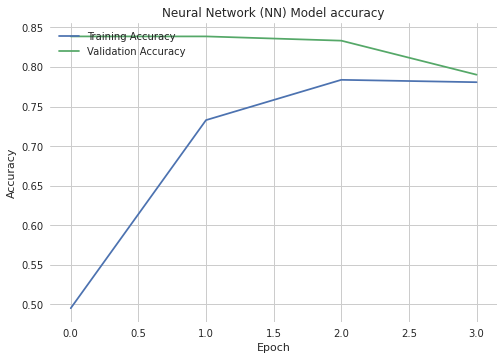

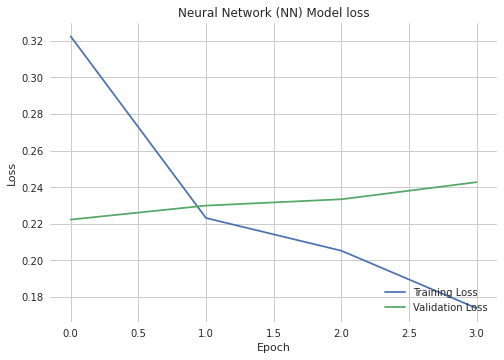

In [ ]:
# Plot training & validation accuracy values
plt.plot(nn_model_fit.history['accuracy'])
plt.plot(nn_model_fit.history['val_accuracy'])
plt.title('Neural Network (NN) Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(nn_model_fit.history['loss'])
plt.plot(nn_model_fit.history['val_loss'])
plt.title('Neural Network (NN) Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='lower right')
plt.show()

### 2) Convolutional Neural Network (CNN)

In [ ]:
CNN_model = Sequential([
    Embedding(input_dim=max_features, input_length=max_len, output_dim=embedding_dims),
    SpatialDropout1D(0.5),
    # ... 100 filters with a kernel size of 4 so that each convolution will consider a window of 4 word embeddings
    Conv1D(filters=100, kernel_size=4, padding='same', activation='relu'),
    #**batch normalization layer** normalizes the activations of the previous layer at each batch, 
    #i.e. applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1. 
    #It will be added after the activation function between a convolutional and a max-pooling layer.
    BatchNormalization(),
    Dropout(0.5),
    GlobalMaxPool1D(),
    Dense(50, activation = 'relu'),
    Dense(6, activation = 'sigmoid')
])

In [ ]:
#Customized the evaluation to analyse the model in terms of accuracy and mean value accuracy
def mean_pred(y_true, y_pred):
    return K.mean(y_pred)

CNN_model.compile(loss='binary_crossentropy', optimizer=Adam(0.01), metrics=['accuracy', precision, recall, mean_pred])

### Visualize the Orchestrated CNN MODEL Architecture

In [ ]:
CNN_model.summary()

In [ ]:
#plot the CNN model architecture

plot_model(CNN_model, to_file='CNN_model_plot.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='CNN_model_plot.png')

In [ ]:
CNN_model_fit = CNN_model.fit(X_train, y_train, batch_size=batch_size2, epochs=3, validation_split=val_split, callbacks=[early])

### Evaluate the CNN Model accuracy of our trained model

In [ ]:
CNN_train_score = CNN_model.evaluate(X_train, y_train, batch_size = batch_size2, verbose = 1)
print('Train loss:', CNN_train_score[0])
print('Train accuracy:', CNN_train_score[1])

### Evaluate the CNN accuracy base our test samples

In [ ]:
CNN_test_score = CNN_model.evaluate(X_test, y_test, batch_size=batch_size2, verbose=1)
print('Test Loss:', CNN_test_score[0])
print('Test Accuracy:', CNN_test_score[1])
p= CNN_test_score[2]
r = CNN_test_score[3]
f = (2*p*r)/(p+r)
print('Test_f1_measure:', f)

In [ ]:
#Predicting......
print('Predicting....')
y_pred = CNN_model.predict(X_test,batch_size=batch_size2,verbose=1)

### Plot Training & Validation Accuracy with the Loss values of the CNN Model

In [ ]:
# Plot training & validation accuracy values
plt.plot(CNN_model_fit.history['accuracy'])
plt.plot(CNN_model_fit.history['val_accuracy'])
plt.title('Convolutional Neural Network (CNN) Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(CNN_model_fit.history['loss'])
plt.plot(CNN_model_fit.history['val_loss'])
plt.title('Convolutional Neural Network (CNN) Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='lower right')
plt.show()

### 3) Recurrent Neural Networks (RNNs)

In [ ]:
RNN_model = Sequential([
    Embedding(input_dim=max_features, input_length=max_len, output_dim=embedding_dims),
    SpatialDropout1D(0.5),
    #Bidirectional layer will enable our model to predict a missing word in a sequence, 
    #So, using this feature will enable the model to look at the context on both the left and the right.
    Bidirectional(LSTM(25, return_sequences=True)),
    #**batch normalization layer** normalizes the activations of the previous layer at each batch, 
    #i.e. applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1. 
    BatchNormalization(),
    Dropout(0.5),
    GlobalMaxPool1D(),
    Dense(50, activation = 'relu'),
    Dense(6, activation = 'sigmoid')
])

In [ ]:
#Customized the evaluation to analyse the model in terms of accuracy and mean value accuracy
def mean_pred(y_true, y_pred):
    return K.mean(y_pred)

RNN_model.compile(loss='binary_crossentropy', optimizer=Adam(0.01), metrics=['accuracy', precision, recall, mean_pred])

### Visualize the Orchestrated RNN MODEL Architecture

In [ ]:
RNN_model.summary()

In [ ]:
#plot the RNN model architecture

plot_model(RNN_model, to_file='CNN_model_plot.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='CNN_model_plot.png')

In [ ]:
RNN_model_fit = RNN_model.fit(X_train, y_train, batch_size=batch_size2, epochs=1, validation_split=val_split, callbacks=[early])

### Evaluate the RNN Model accuracy of our trained model

In [ ]:
RNN_train_score = RNN_model.evaluate(X_train, y_train, batch_size=batch_size2, verbose=1)
print('Train Loss:', RNN_train_score[0])
print('Train Accuracy:', RNN_train_score[1])

### Evaluate the RNN accuracy base our test samples

In [ ]:
RNN_test_score = RNN_model.evaluate(X_test, y_test, batch_size=batch_size2, verbose=1)
print('Test Loss:', RNN_test_score[0])
print('Test Accuracy:', RNN_test_score[1])
p= RNN_test_score[2]
r = RNN_test_score[3]
f = (2*p*r)/(p+r)
print('Test_f1_measure:', f)

### Plot Training & Validation Accuracy with the Loss values of the RNN Model

In [ ]:
# Plot training & validation accuracy values
plt.plot(RNN_model_fit.history['accuracy'])
plt.plot(RNN_model_fit.history['val_accuracy'])
plt.title('Recurrent Neural Networks (RNNs) Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(RNN_model_fit.history['loss'])
plt.plot(RNN_model_fit.history['val_loss'])
plt.title('Recurrent Neural Networks (RNNs) Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='lower right')
plt.show()

### USING PRE-TRAINED EMBEDDING

## A) "Word2Vec" as a pre-Trained Embedding

Firstly, we separately learnt word embeddings and then pass to the embedding layer. This approach allows to use  pre-trained (Word2Vec) word embedding and also saves the time in training the classification model.

In this part of experiment, we used Gensim implementaion of Word2Vec.

### Create the word tokens in order to prepare the Text corpus for leanring the embedding

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
toxicComments_lines = list()
lines = train['text'].values.tolist()

for line in lines:
    tokens = word_tokenize(line)
    
    #convert to lower case
    tokens = [w.lower() for w in tokens]
    
    #remove punctuation from each word
    table =  str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    
    #remove remaining tpkens gthat are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    
    #filter out stop words
    # stop_words = set(stopwords.words('english'))
    #words = [w for w in words if not w in stop_words]
    toxicComments_lines.append(words)


len(toxicComments_lines)

1856

### Train the Word2Vec

In [ ]:
#train word2vec mode
embedding_dims = 128 #embedding vector output dimension 
max_len = 200 #Max. number of words per toxic comment to be use
word2VecModel = gensim.models.Word2Vec(sentences=toxicComments_lines, size= embedding_dims, window=5, workers=4, min_count=1)
#vocab size
wors = list(word2VecModel.wv.vocab)
print('Vocabulary size: %d' % len(words))

Vocabulary size: 11


#### Test Word2Vec Model of the toxic comment corpus. We tried some word embeddings from the model learnt from the wikipedia toxic comment tran dataset

In [ ]:
#word2VecModel.wv.most_similar('shit')

In [ ]:
#Let's see the reulst of semantically reasonable word vetors (king - man + woman)
#word2VecModel.wv.most_similar_cosmul(positive=['woman', 'king'], negative=['man'])

In [ ]:
#Let us find the odd word woman, king, queen, movie = ?
#add word out
#print(word2VecModel.wv.doesnt_match("woman king queen movie".split()))

#### Save the Word2Vec Corpus locally

In [ ]:
#save model
filename = 'toxic_embedding_word2vec.txt'
word2VecModel.wv.save_word2vec_format(filename, binary=False)

### Use the Pre-Trained Embedding (Word2Vec) in our models (CNN, and RNN)

In [ ]:
word2Vec_embeddings_index = {}
word2vec_file = open(os.path.join('', 'toxic_embedding_word2vec.txt'), encoding = "utf-8")

for line in word2vec_file:
    values = line.split()
    word = values[0]
    coefficient = np.asarray(values[1:])
    word2Vec_embeddings_index[word] = coefficient
word2vec_file.close()

#### Convert the word embedding into tokenized vector

In [ ]:
#vectorize the text samples into a 2D integer tensor
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(toxicComments_lines)
sequences = tokenizer_obj.texts_to_sequences(toxicComments_lines)

#pad sequences
word_index = tokenizer_obj.word_index
print('Found %s uniquue tokens.' % len(word_index))

toxicComments_pad = pad_sequences(sequences, maxlen=max_len)
comments_tag = train[["Relevant information is missing", "Irrelevant information is added", "Out of context information is added", "Misleading original context", "Factual incorrectness", "Repetitive information is found"]].values
#comments_tag = train[["Relevant information is missing", "Irrelevant information added", "Out of context information added", "Misleading original context", "Factual incorrectness", "Repetitive information found"]].values
#comments_tag = train[["Lengthy summary", "Novel sentence structure is missing","Copied sentences present", "Sentence formation needs to be improved" ]].values
#comments_tag= train[["syntax or semantic errors", "coherence issue", "understandability issue", "unnatural sentence formations "]].values

print('Shape of toxic comments tensor', toxicComments_pad.shape)
print('Shape of comment tensor', comments_tag.shape)

Found 696 uniquue tokens.
Shape of toxic comments tensor (1856, 200)
Shape of comment tensor (1856, 6)


#### We mapped the embeddings from the loaded word2vec model so that each word to the tokenizer_obj.word_index vocabulary and create a matrix with of word vectors.

In [ ]:
num_words = len(word_index)+1
word2Vec_embedding_matrix = np.zeros((num_words, embedding_dims))

for word, i  in word_index.items():
    if i > num_words:
        continue
    word2Vec_embedding_vector = word2Vec_embeddings_index.get(word)
    if word2Vec_embedding_vector is not None:
        #words not found in embedding index will be all-zeros.
        word2Vec_embedding_matrix[i] = word2Vec_embedding_vector

print(num_words)
print(word2Vec_embedding_matrix.shape[0])
print(word2Vec_embedding_matrix.shape[1])

697
697
128


### 6) Convolutional Neural Network (CNN) with Word2Vec

In [ ]:
CNN_Word2Vec_model = Sequential([
    Embedding(input_dim =word2Vec_embedding_matrix.shape[0], input_length=max_len, output_dim=word2Vec_embedding_matrix.shape[1],weights=[word2Vec_embedding_matrix], trainable=False),
    SpatialDropout1D(0.5),
    # ... 100 filters with a kernel size of 4 so that each convolution will consider a window of 4 word embeddings
    Conv1D(filters=100, kernel_size=4, padding='same', activation='relu'),
    #**batch normalization layer** normalizes the activations of the previous layer at each batch, 
    #i.e. applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1. 
    #It will be added after the activation function between a convolutional and a max-pooling layer.
    BatchNormalization(),
    GlobalMaxPool1D(),
    Dropout(0.5),
    Dense(50, activation = 'relu'),
    Dense(6, activation = 'sigmoid')
])

In [ ]:
#Customized the evaluation to analyse the model in terms of accuracy and mean value accuracy
def mean_pred(y_true, y_pred):
    return K.mean(y_pred)

CNN_Word2Vec_model.compile(loss='binary_crossentropy', optimizer=Adam(0.01), metrics=['accuracy', precision, recall, mean_pred])


#### Visualize the Orchestrated CNN-Glove Model Architecture

In [ ]:
CNN_Word2Vec_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 200, 128)          89216     
                                                                 
 spatial_dropout1d_3 (Spatia  (None, 200, 128)         0         
 lDropout1D)                                                     
                                                                 
 conv1d_3 (Conv1D)           (None, 200, 100)          51300     
                                                                 
 batch_normalization_3 (Batc  (None, 200, 100)         400       
 hNormalization)                                                 
                                                                 
 global_max_pooling1d_3 (Glo  (None, 100)              0         
 balMaxPooling1D)                                                
                                                      

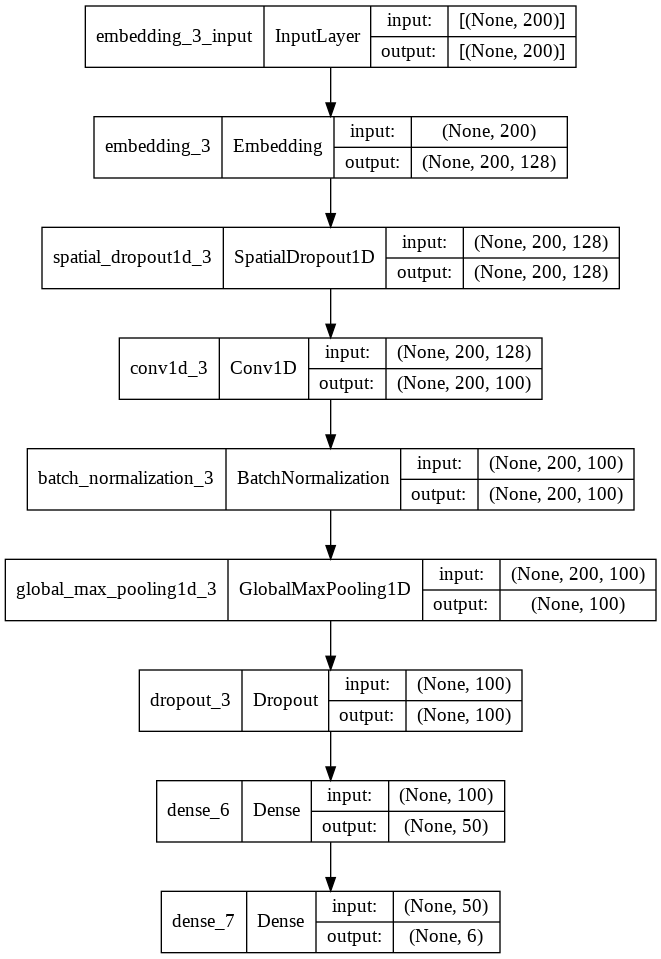

In [ ]:
#plot the CNN_Word2Vec_model architecture

plot_model(CNN_Word2Vec_model, to_file='CNN_Word2Vec_model_plot.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='CNN_Word2Vec_model_plot.png')

In [ ]:
CNN_Word2Vec_model_fit = CNN_Word2Vec_model.fit(X_train, y_train, batch_size=batch_size2, epochs=num_epochs, validation_split=val_split, callbacks=[early])

Epoch 1/100
53/53 [==============================] - 1s 11ms/step - loss: 0.2243 - accuracy: 0.8204 - precision: 0.0000e+00 - recall: 0.0000e+00 - mean_pred: 0.0745 - val_loss: 0.2232 - val_accuracy: 0.8387 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_mean_pred: 0.0768
Epoch 2/100
53/53 [==============================] - 1s 11ms/step - loss: 0.2232 - accuracy: 0.8210 - precision: 0.0000e+00 - recall: 0.0000e+00 - mean_pred: 0.0734 - val_loss: 0.2241 - val_accuracy: 0.8387 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_mean_pred: 0.0800
Epoch 3/100
53/53 [==============================] - 1s 11ms/step - loss: 0.2235 - accuracy: 0.8210 - precision: 0.0000e+00 - recall: 0.0000e+00 - mean_pred: 0.0764 - val_loss: 0.2229 - val_accuracy: 0.8387 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_mean_pred: 0.0717
Epoch 4/100
53/53 [==============================] - 1s 11ms/step - loss: 0.2232 - accuracy: 0.8204 - precision: 0.0000e+00 - recall: 0.0000e+00 - m

#### Evaluate the CNN+Word2Vec Model accuracy of our trained model

In [ ]:
CNN_Word2Vec_train_score = CNN_Word2Vec_model.evaluate(X_train, y_train, batch_size=batch_size2, verbose=1)
print('Train Loss:', CNN_Word2Vec_train_score[0])
print('Train Accuracy:', CNN_Word2Vec_train_score[1])

58/58 [==============================] - 1s 5ms/step - loss: 0.2268 - accuracy: 0.8227 - precision: 0.0000e+00 - recall: 0.0000e+00 - mean_pred: 0.0575
Train Loss: 0.2268182784318924
Train Accuracy: 0.8227370977401733


#### Evaluate the CNN+Word2Vec accuracy base our test samples

In [ ]:
CNN_Word2Vec_test_score = CNN_Word2Vec_model.evaluate(X_test, y_test, batch_size=batch_size2, verbose=1)
print('Test Loss:', CNN_Word2Vec_test_score[0])
print('Test Accuracy:', CNN_Word2Vec_test_score[1])
p= CNN_Word2Vec_test_score[2]
r = CNN_Word2Vec_test_score[3]
f = (2*p*r)/(p+r)
print('Test_f1_measure:', f)

In [ ]:
#Predicting......
print('Predicting....')
y_pred = CNN_Word2Vec_model.predict(X_test,batch_size=batch_size2,verbose=1)

Predicting....
8/8 [==============================] - 0s 4ms/step


#### Plot Training & Validation Accuracy with the Loss values of the CNN-Word2Vec Model

In [ ]:
# Plot training & validation accuracy values
plt.plot(CNN_Word2Vec_model_fit.history['accuracy'])
plt.plot(CNN_Word2Vec_model_fit.history['val_accuracy'])
plt.title('CNN-Word2Vec Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()


In [ ]:
# Plot training & validation loss values
plt.plot(CNN_Word2Vec_model_fit.history['loss'])
plt.plot(CNN_Word2Vec_model_fit.history['val_loss'])
plt.title('CNN-Word2Vec Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='lower right')
plt.show()

### 7) Recurrent Neural Network (RNN) with Word2Vec

In [ ]:
RNN_Word2Vec_model = Sequential([
    Embedding(input_dim =word2Vec_embedding_matrix.shape[0], input_length=max_len, output_dim=word2Vec_embedding_matrix.shape[1],weights=[word2Vec_embedding_matrix], trainable=False),
    SpatialDropout1D(0.5),
    #Bidirectional layer will enable our model to predict a missing word in a sequence, 
    #So, using this feature will enable the model to look at the context on both the left and the right.
    Bidirectional(LSTM(25, return_sequences=True)),
    #**batch normalization layer** normalizes the activations of the previous layer at each batch, 
    #i.e. applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1. 
    BatchNormalization(),
    Dropout(0.5),
    GlobalMaxPool1D(),
    Dense(50, activation = 'relu'),
    Dense(4, activation = 'sigmoid')
])

In [ ]:
#Customized the evaluation to analyse the model in terms of accuracy and mean value accuracy
def mean_pred(y_true, y_pred):
    return K.mean(y_pred)

RNN_Word2Vec_model.compile(loss='binary_crossentropy', optimizer=Adam(0.01), metrics=['accuracy', precision, recall, mean_pred])

####Visualize the Orchestrated RNN-Word2Vec Model Architecture

In [ ]:
RNN_Word2Vec_model.summary()

Model: "sequential_68"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_68 (Embedding)     (None, 200, 128)          89216     
_________________________________________________________________
spatial_dropout1d_51 (Spatia (None, 200, 128)          0         
_________________________________________________________________
bidirectional_22 (Bidirectio (None, 200, 50)           30800     
_________________________________________________________________
batch_normalization_51 (Batc (None, 200, 50)           200       
_________________________________________________________________
dropout_68 (Dropout)         (None, 200, 50)           0         
_________________________________________________________________
global_max_pooling1d_68 (Glo (None, 50)                0         
_________________________________________________________________
dense_136 (Dense)            (None, 50)              

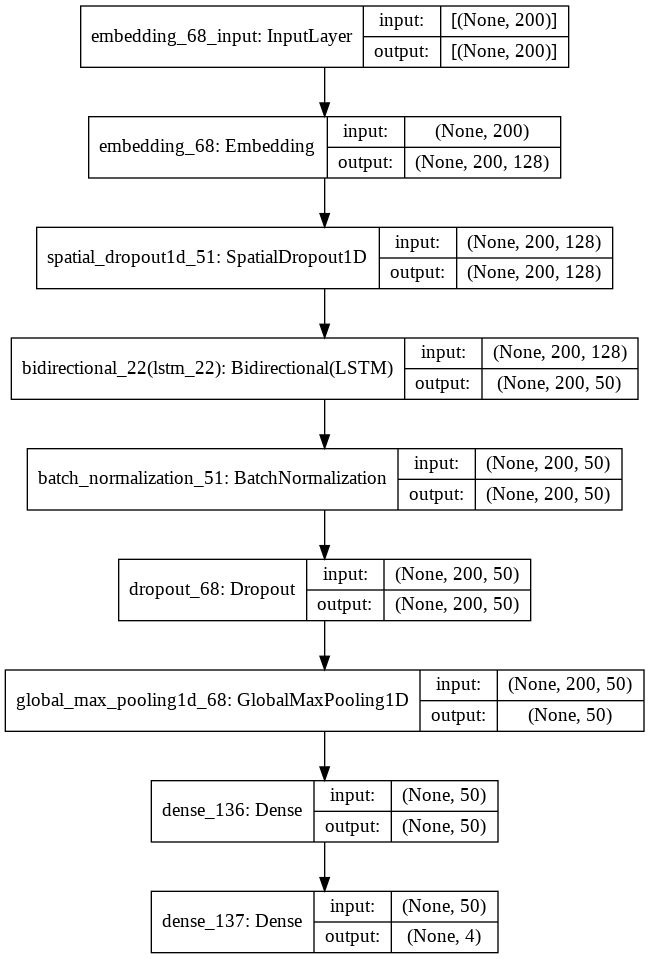

In [ ]:
#plot the RNN_Word2Vec_model architecture

plot_model(RNN_Word2Vec_model, to_file='RNN_Word2Vec_model_plot.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='RNN_Word2Vec_model_plot.png')

In [ ]:
RNN_Word2Vec_model_fit = RNN_Word2Vec_model.fit(X_train, y_train, batch_size=batch_size2, epochs=num_epochs, validation_split=val_split, callbacks=[early])

Epoch 1/4
27/27 [==============================] - 8s 118ms/step - loss: 0.4444 - accuracy: 0.3174 - precision: 0.1584 - recall: 0.0817 - mean_pred: 0.1286 - val_loss: 0.5971 - val_accuracy: 0.3011 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_mean_pred: 0.4393
Epoch 2/4
27/27 [==============================] - 2s 79ms/step - loss: 0.3135 - accuracy: 0.3138 - precision: 0.0375 - recall: 0.0332 - mean_pred: 0.1238 - val_loss: 0.5934 - val_accuracy: 0.6290 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_mean_pred: 0.4346
Epoch 3/4
27/27 [==============================] - 2s 79ms/step - loss: 0.3053 - accuracy: 0.3204 - precision: 0.0000e+00 - recall: 0.0000e+00 - mean_pred: 0.1177 - val_loss: 0.5524 - val_accuracy: 0.3011 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_mean_pred: 0.4088
Epoch 4/4
27/27 [==============================] - 2s 78ms/step - loss: 0.3141 - accuracy: 0.2934 - precision: 0.0000e+00 - recall: 0.0000e+00 - mean_pred: 0.1177 - val_

#### Evaluate the RNN+Word2Vec Model accuracy of our trained model

In [ ]:
RNN_Word2Vec_train_score = RNN_Word2Vec_model.evaluate(X_train, y_train, batch_size=batch_size2, verbose=1)
print('Train Loss:', RNN_Word2Vec_train_score[0])
print('Train Accuracy:', RNN_Word2Vec_train_score[1])

29/29 [==============================] - 2s 31ms/step - loss: 0.5583 - accuracy: 0.3001 - precision: 0.0000e+00 - recall: 0.0000e+00 - mean_pred: 0.4115
Train Loss: 0.5583246350288391
Train Accuracy: 0.3001077473163605


#### Evaluate the RNN+Word2Vec accuracy base our test samples

In [ ]:
RNN_Word2Vec_test_score = RNN_Word2Vec_model.evaluate(X_test, y_test, batch_size=batch_size2, verbose=1)
print('Test Loss:', RNN_Word2Vec_test_score[0])
print('Test Accuracy:', RNN_Word2Vec_test_score[1])
p= RNN_Word2Vec_test_score[2]
r = RNN_Word2Vec_test_score[3]
f = (2*p*r)/(p+r)
print('Test_f1_measure:', f)


In [ ]:
#Predicting......
print('Predicting....')
y_pred = RNN_Word2Vec_model.predict(X_test,batch_size=batch_size2,verbose=1)

Predicting....
8/8 [==============================] - 1s 27ms/step


#### Plot Training & Validation Accuracy with the Loss values of the RNN-Word2Vec Model

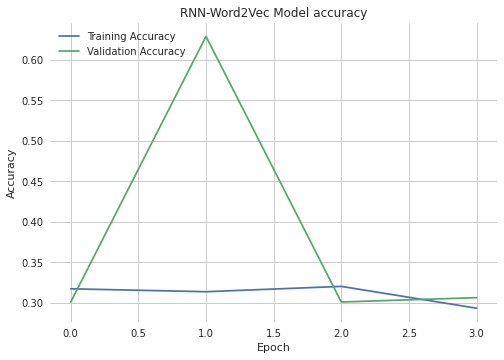

In [ ]:
# Plot training & validation accuracy values
plt.plot(RNN_Word2Vec_model_fit.history['accuracy'])
plt.plot(RNN_Word2Vec_model_fit.history['val_accuracy'])
plt.title('RNN-Word2Vec Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()

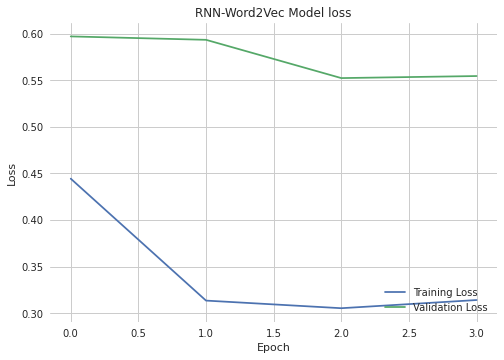

In [ ]:
# Plot training & validation loss values
plt.plot(RNN_Word2Vec_model_fit.history['loss'])
plt.plot(RNN_Word2Vec_model_fit.history['val_loss'])
plt.title('RNN-Word2Vec Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='lower right')
plt.show()

## B) "FastText" as a pre-trained Embedding

#### Load the FastText Word Embeddng Corpus

In [ ]:
#load embeddings
print('loading word embeddings...')
fastText_embeddings_index = {}
f = codecs.open('/content/drive/MyDrive/Question Classifier Telugu/cc.te.300.vec', encoding='utf-8')
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    #word_index = values.word_index
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    fastText_embeddings_index[word] = coefs
f.close()
print('found %s word vectors' % len(fastText_embeddings_index))

loading word embeddings...


1878289it [04:25, 7075.71it/s]

found 1878289 word vectors


In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
toxicComments_lines = list()
lines = train['text'].values.tolist()

for line in lines:
    tokens = word_tokenize(line)
    
    #convert to lower case
    tokens = [w.lower() for w in tokens]
    
    #remove punctuation from each word
    table =  str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    
    #remove remaining tpkens gthat are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    
    #filter out stop words
    # stop_words = set(stopwords.words('english'))
    # words = [w for w in words if not w in stop_words]
    toxicComments_lines.append(words)


len(toxicComments_lines)

1856

In [ ]:
#vectorize the text samples into a 2D integer tensor
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(toxicComments_lines)
sequences = tokenizer_obj.texts_to_sequences(toxicComments_lines)

#pad sequences
word_index = tokenizer_obj.word_index
print('Found %s uniquue tokens.' % len(word_index))

Found 696 uniquue tokens.


In [ ]:
#embedding matrix
print('preparing embedding matrix...')
max_nb_words = 100000
fastText_embed_dim = 300 
# word_index=[1, 2, 3]
print(len(word_index))
words_not_found = []
nb_words = min(max_nb_words, len(word_index))
fastText_embedding_matrix = np.zeros((nb_words, fastText_embed_dim))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    fastText_embedding_vector = fastText_embeddings_index.get(word)
    if (fastText_embedding_vector is not None) and len(fastText_embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        fastText_embedding_matrix[i] = fastText_embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(fastText_embedding_matrix, axis=1) == 0))

preparing embedding matrix...
696
number of null word embeddings: 108


In [ ]:
print(nb_words)

696


### 8) Convolutional Neural Network (CNN) with FastText

In [ ]:
CNN_FastText_model = Sequential([
    Embedding(input_dim=fastText_embedding_matrix.shape[0], input_length=max_len, output_dim=fastText_embedding_matrix.shape[1],weights=[fastText_embedding_matrix], trainable=False),
    SpatialDropout1D(0.5),
    # ... 100 filters with a kernel size of 4 so that each convolution will consider a window of 4 word embeddings
    Conv1D(filters=100, kernel_size=4, padding='same', activation='relu'),
    #**batch normalization layer** normalizes the activations of the previous layer at each batch, 
    #i.e. applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1. 
    #It will be added after the activation function between a convolutional and a max-pooling layer.
    BatchNormalization(),
    GlobalMaxPool1D(),
    Dropout(0.5),
    Dense(50, activation = 'relu'),
    Dense(4, activation = 'sigmoid')
])

In [ ]:
#Customized the evaluation to analyse the model in terms of accuracy and mean value accuracy
def mean_pred(y_true, y_pred):
    return K.mean(y_pred)

In [ ]:
CNN_FastText_model.compile(loss='binary_crossentropy', optimizer=Adam(0.01), metrics=['accuracy', precision, recall, mean_pred])

#### Visualize the Orchestrated CNN-FastText Model Architecture

In [ ]:
CNN_FastText_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 200, 300)          208800    
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 200, 300)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 200, 100)          120100    
_________________________________________________________________
batch_normalization_2 (Batch (None, 200, 100)          400       
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 100)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 50)               

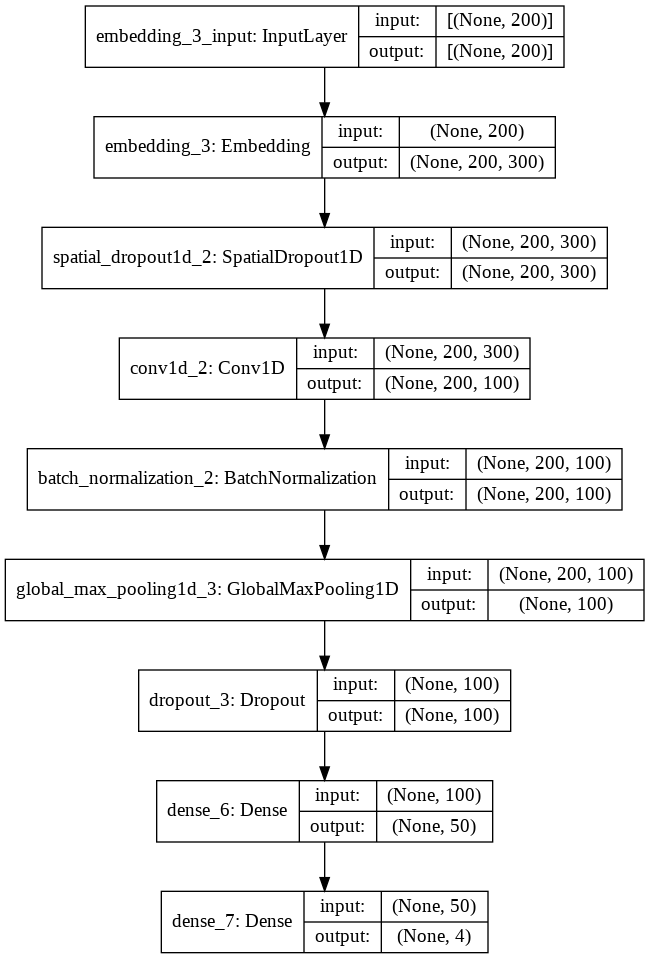

In [ ]:
#plot the CNN_FastText_model architecture

plot_model(CNN_FastText_model, to_file='CNN_FastText_model_plot.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='CNN_FastText_model_plot.png')

In [ ]:
CNN_FastText_model_fit = CNN_FastText_model.fit(X_train, y_train, batch_size=64, epochs=num_epochs, validation_split=val_split, callbacks=[early])

Epoch 1/25
27/27 [==============================] - 2s 29ms/step - loss: 0.6992 - accuracy: 0.3168 - precision: 0.2439 - recall: 0.1469 - mean_pred: 0.1312 - val_loss: 0.5603 - val_accuracy: 0.3011 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_mean_pred: 0.4146
Epoch 2/25
27/27 [==============================] - 1s 20ms/step - loss: 0.3267 - accuracy: 0.2964 - precision: 0.1852 - recall: 0.0060 - mean_pred: 0.1293 - val_loss: 0.5176 - val_accuracy: 0.3011 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_mean_pred: 0.3813
Epoch 3/25
27/27 [==============================] - 1s 19ms/step - loss: 0.3196 - accuracy: 0.2850 - precision: 0.0926 - recall: 0.0036 - mean_pred: 0.1231 - val_loss: 0.4862 - val_accuracy: 0.3011 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_mean_pred: 0.3571
Epoch 4/25
27/27 [==============================] - 1s 19ms/step - loss: 0.3166 - accuracy: 0.2832 - precision: 0.0370 - recall: 0.0012 - mean_pred: 0.1263 - val_loss: 0.4636 

#### Evaluate the CNN+fastText Model accuracy of our trained model

In [ ]:
CNN_FastText_train_score = CNN_FastText_model.evaluate(X_train, y_train, batch_size=batch_size2, verbose=1)
print('Train Loss:', CNN_FastText_train_score[0])
print('Train Accuracy:', CNN_FastText_train_score[1])

58/58 [==============================] - 1s 7ms/step - loss: 0.2969 - accuracy: 0.2850 - precision: 0.0000e+00 - recall: 0.0000e+00 - mean_pred: 0.1168
Train Loss: 0.29692089557647705
Train Accuracy: 0.2850215435028076


#### Evaluate the CNN+FastText accuracy base our test samples

In [ ]:
CNN_FastText_test_score = CNN_FastText_model.evaluate(X_test, y_test, batch_size=32, verbose=1)
print('Test Loss:', CNN_FastText_test_score[0])
print('Test Accuracy:', CNN_FastText_test_score[1])
p= CNN_FastText_test_score[2]
r = CNN_FastText_test_score[3]
f = (2*p*r)/(p+r)
print('Test_f1_measure:', f)

15/15 [==============================] - 0s 7ms/step - loss: 0.3160 - accuracy: 0.2802 - precision: 0.0000e+00 - recall: 0.0000e+00 - mean_pred: 0.1166
Test Loss: 0.3159739673137665
Test Accuracy: 0.2801724076271057


ZeroDivisionError: ignored

In [ ]:
#Predicting......
print('Predicting....')
y_pred = CNN_FastText_model.predict(X_test,batch_size=batch_size2,verbose=1)

Predicting....
4/4 [==============================] - 0s 5ms/step


#### Plot Training & Validation Accuracy with the Loss values of the CNN-FastText Model

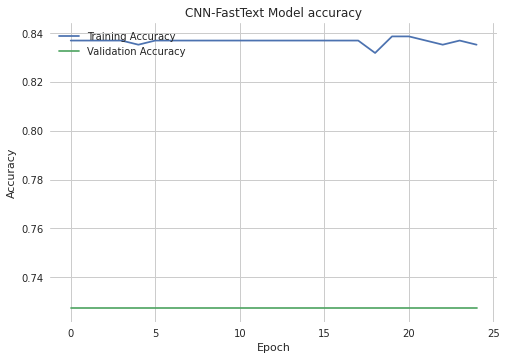

In [ ]:
# Plot training & validation accuracy values
plt.plot(CNN_FastText_model_fit.history['accuracy'])
plt.plot(CNN_FastText_model_fit.history['val_accuracy'])
plt.title('CNN-FastText Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()

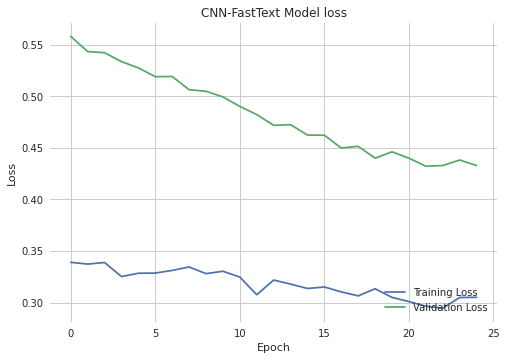

In [ ]:
# Plot training & validation loss values
plt.plot(CNN_FastText_model_fit.history['loss'])
plt.plot(CNN_FastText_model_fit.history['val_loss'])
plt.title('CNN-FastText Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='lower right')
plt.show()

### 9) Recurrent Neural Network (RNN) with FastText

In [ ]:
RNN_FastText_model = Sequential([
    Embedding(input_dim =fastText_embedding_matrix.shape[0], input_length=max_len, output_dim=fastText_embedding_matrix.shape[1],weights=[fastText_embedding_matrix], trainable=False),
    SpatialDropout1D(0.5),
    #Bidirectional layer will enable our model to predict a missing word in a sequence, 
    #So, using this feature will enable the model to look at the context on both the left and the right.
    Bidirectional(LSTM(25, return_sequences=True)),
    #**batch normalization layer** normalizes the activations of the previous layer at each batch, 
    #i.e. applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1. 
    BatchNormalization(),
    Dropout(0.5),
    GlobalMaxPool1D(),
    Dense(50, activation = 'relu'),
    Dense(4, activation = 'sigmoid')
])

In [ ]:
#Customized the evaluation to analyse the model in terms of accuracy and mean value accuracy
def mean_pred(y_true, y_pred):
    return K.mean(y_pred)

In [ ]:
RNN_FastText_model.compile(loss='binary_crossentropy', optimizer=Adam(0.01), metrics=['accuracy', precision, recall, mean_pred])

#### Visualize the Orchestrated RNN-fastText Model Architecture

In [ ]:
RNN_FastText_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 200, 300)          208800    
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 200, 300)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 200, 50)           65200     
_________________________________________________________________
batch_normalization_3 (Batch (None, 200, 50)           200       
_________________________________________________________________
dropout_4 (Dropout)          (None, 200, 50)           0         
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 50)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 50)               

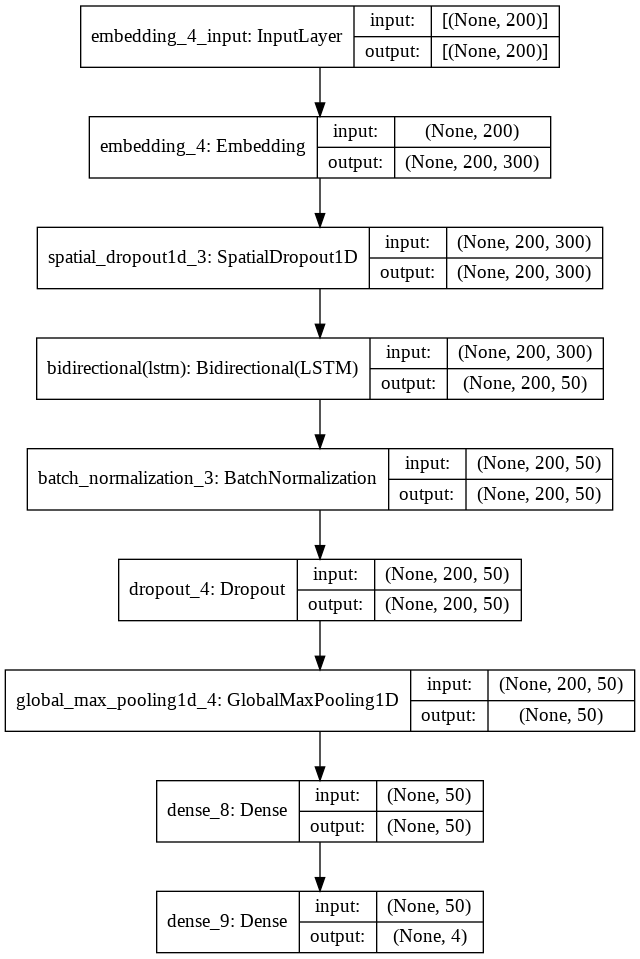

In [ ]:
#plot the RNN_FastText_model architecture

plot_model(RNN_FastText_model, to_file='RNN_FastText_model_plot.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='RNN_FastText_model_plot.png')

In [ ]:
RNN_FastText_model_fit = RNN_FastText_model.fit(X_train, y_train, batch_size=batch_size2, epochs=num_epochs, validation_split=val_split, callbacks=[early])

Epoch 1/25
53/53 [==============================] - 10s 95ms/step - loss: 0.4060 - accuracy: 0.2892 - precision: 0.1668 - recall: 0.0853 - mean_pred: 0.1264 - val_loss: 0.5494 - val_accuracy: 0.3011 - val_precision: 0.3038 - val_recall: 0.6876 - val_mean_pred: 0.4129
Epoch 2/25
53/53 [==============================] - 4s 76ms/step - loss: 0.3251 - accuracy: 0.2910 - precision: 0.0384 - recall: 0.0365 - mean_pred: 0.1207 - val_loss: 0.4998 - val_accuracy: 0.3011 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_mean_pred: 0.3714
Epoch 3/25
53/53 [==============================] - 4s 75ms/step - loss: 0.3167 - accuracy: 0.3138 - precision: 0.1220 - recall: 0.0173 - mean_pred: 0.1211 - val_loss: 0.5172 - val_accuracy: 0.3011 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_mean_pred: 0.3800
Epoch 4/25
53/53 [==============================] - 4s 75ms/step - loss: 0.3106 - accuracy: 0.3150 - precision: 0.1038 - recall: 0.0080 - mean_pred: 0.1224 - val_loss: 0.5106 - val_a

#### Evaluate the RNN+fastText Model accuracy of our trained model

In [ ]:
RNN_FastText_train_score = RNN_FastText_model.evaluate(X_train, y_train, batch_size=batch_size2, verbose=1)
print('Train Loss:', RNN_FastText_train_score[0])
print('Train Accuracy:', RNN_FastText_train_score[1])

58/58 [==============================] - 3s 29ms/step - loss: 0.3403 - accuracy: 0.3233 - precision: 0.1552 - recall: 0.0113 - mean_pred: 0.2221
Train Loss: 0.34030210971832275
Train Accuracy: 0.3232758641242981


#### Evaluate the RNN+FastText accuracy base our test samples

In [ ]:
RNN_FastText_test_score = RNN_FastText_model.evaluate(X_test, y_test, batch_size=batch_size2, verbose=1)
print('Test Loss:', RNN_FastText_test_score[0])
print('Test Accuracy:', RNN_FastText_test_score[1])
p= RNN_FastText_test_score[2]
r = RNN_FastText_test_score[3]
f = (2*p*r)/(p+r)
print('Test_f1_measure:', f)

15/15 [==============================] - 0s 30ms/step - loss: 0.3595 - accuracy: 0.2845 - precision: 0.0000e+00 - recall: 0.0000e+00 - mean_pred: 0.2219
Test Loss: 0.3595355451107025
Test Accuracy: 0.2844827473163605


ZeroDivisionError: ignored

In [ ]:
#Predicting......
print('Predicting....')
y_pred = RNN_FastText_model.predict(X_test,batch_size=batch_size2,verbose=1)

Predicting....
7/7 [==============================] - 1s 26ms/step


#### Plot Training & Validation Accuracy with the Loss values of the RNN-fastText Model

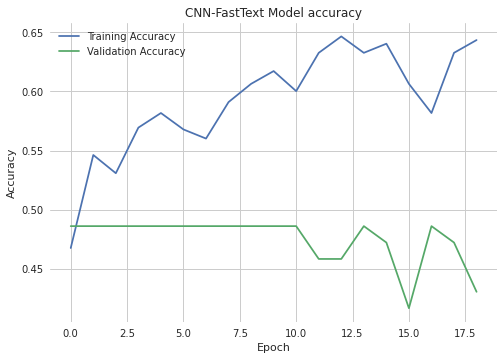

In [ ]:
# Plot training & validation accuracy values
plt.plot(RNN_FastText_model_fit.history['accuracy'])
plt.plot(RNN_FastText_model_fit.history['val_accuracy'])
plt.title('CNN-FastText Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()

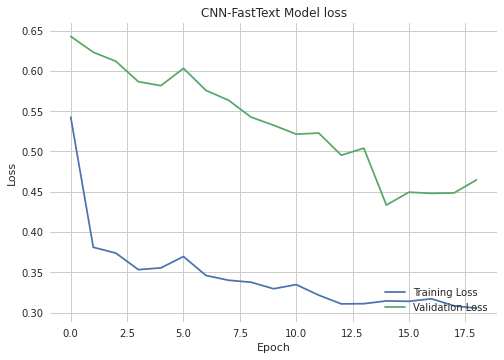

In [ ]:
# Plot training & validation loss values
plt.plot(RNN_FastText_model_fit.history['loss'])
plt.plot(RNN_FastText_model_fit.history['val_loss'])
plt.title('CNN-FastText Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='lower right')
plt.show()

### EVALUATION

#### Computing the highest of the evaluation matrics (per model) 

In [ ]:
trace = go.Table(
    header=dict(values=['Model', 'Loss', 'Accuracy', 'mean_pred', 'F-Measure', 'Precision', 'AUC', 'Recall'],
                line = dict(color='#7D7F80'),
                fill = dict(color='#a1c3d1'),
                align = ['left'] * 5),
    cells=dict(values=[['Neural Network', 'CNN', 'RNNs', 'CNNs-Word2Vec', 'RNNs-Word2Vec', 'CNNs-FastText', 'RNNs-FastText'],
                       [
                        #Loss Evaluation
                        round(np.max(nn_model_fit.history['loss']), 3), round(np.max(CNN_model_fit.history['loss']), 3), round(np.max(RNN_model_fit.history['loss']), 3), 
                        round(np.max(CNN_Word2Vec_model_fit.history['loss']), 3),
                        round(np.max(RNN_Word2Vec_model_fit.history['loss']), 3), round(np.max(CNN_FastText_model_fit.history['loss']), 3), round(np.max(RNN_FastText_model_fit.history['loss']), 3)],
                        
                        #Accuracy Evaluation
                        [round(np.max(nn_model_fit.history['accuracy']), 3), round(np.max(CNN_model_fit.history['accuracy']), 3), round(np.max(RNN_model_fit.history['accuracy']), 3), 
                         round(np.max(CNN_Word2Vec_model_fit.history['accuracy']), 3), 
                        round(np.max(RNN_Word2Vec_model_fit.history['accuracy']), 3), round(np.max(CNN_FastText_model_fit.history['accuracy']), 3), round(np.max(RNN_FastText_model_fit.history['accuracy']), 3)],
               
                      #   #mean_pred Evaluation
                      #   [round(np.max(nn_model_fit.history['mean_pred']), 3), round(np.max(CNN_model_fit.history['mean_pred']), 3), round(np.max(RNN_model_fit.history['mean_pred']), 3), 
                      #    round(np.max(CNN_Word2Vec_model_fit.history['mean_pred']), 3), 
                      #   round(np.max(RNN_Word2Vec_model_fit.history['mean_pred']), 3), round(np.max(CNN_FastText_model_fit.history['mean_pred']), 3), round(np.max(RNN_FastText_model_fit.history['mean_pred']),3)],
               
                      #   #F1-Measure Evaluation
                      #   [round(np.max(nn_model_fit.history['fmeasure']), 3), round(np.max(CNN_model_fit.history['fmeasure']), 3), round(np.max(RNN_model_fit.history['fmeasure']), 3), 
                      #    round(np.max(CNN_Word2Vec_model_fit.history['fmeasure']), 3), 
                      #   round(np.max(RNN_Word2Vec_model_fit.history['fmeasure']), 3), round(np.max(CNN_FastText_model_fit.history['fmeasure']), 3), round(np.max(RNN_FastText_model_fit.history['fmeasure']), 3)],
               
                      #   #Precision Evaluation
                      #   [round(np.max(nn_model_fit.history['precision']), 3), round(np.max(CNN_model_fit.history['precision']), 3), round(np.mean(RNN_model_fit.history['precision']), 3), 
                      #    round(np.mean(CNN_Word2Vec_model_fit.history['precision']), 3), 
                      #   round(np.max(RNN_Word2Vec_model_fit.history['precision']), 3), round(np.max(CNN_FastText_model_fit.history['precision']), 3), round(np.mean(RNN_FastText_model_fit.history['precision']), 3)],
                        
                      #   #ROC AUC Evaluation
                      #   [round(np.max(nn_model_fit.history['auroc']), 3), round(np.max(CNN_model_fit.history['auroc']), 3), round(np.max(RNN_model_fit.history['auroc']), 3), 
                      #    round(np.max(CNN_Word2Vec_model_fit.history['auroc']), 3), 
                      #   round(np.max(RNN_Word2Vec_model_fit.history['auroc']), 3), round(np.max(CNN_FastText_model_fit.history['auroc']), 3), round(np.max(RNN_FastText_model_fit.history['auroc']), 3)],
                       
                       
                      #   #Recall Evaluation
                      #   [round(np.max(nn_model_fit.history['recall']), 3), round(np.max(CNN_model_fit.history['recall']), 3), round(np.max(RNN_model_fit.history['recall']), 3), 
                      #    round(np.max(CNN_Word2Vec_model_fit.history['recall']), 3), 
                      #   round(np.max(RNN_Word2Vec_model_fit.history['recall']), 3), round(np.max(CNN_FastText_model_fit.history['recall']), 3), round(np.max(RNN_FastText_model_fit.history['recall']), 3)]
                      #  ],
              #  line = dict(color='#7D7F80'),
              #  fill = dict(color='#EDFAFF'),
              #  align = ['left'] * 5))

layout = dict(width=800, height=400)
data = [trace]
fig = dict(data=data, layout=layout)
py.iplot(data, filename = 'multi-label_with the max of the evaluation matrics (per model) _table')